In [1]:
import os
import re
import time
import pandas as pd
import xarray as xr
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize

In [2]:
import cellregmap 
cellregmap 

<module 'cellregmap' from '/hps/nobackup/stegle/users/acuomo/git_repos/CellRegMap/cellregmap/__init__.py'>

In [3]:
from cellregmap import run_interaction

In [4]:
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [5]:
## sample mapping file
## this file will map cells to donors 
## it will also only include donors we have single-cell data for (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [6]:
## genotype_individual_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## phenotype_sample_id are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0114i-joxm_1,21843_1#10
1,HPSI0314i-fafq_1,21843_1#100
2,HPSI0314i-fafq_1,21843_1#101
3,HPSI1013i-wuye_2,21843_1#102
4,HPSI0114i-joxm_1,21843_1#103


In [7]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [8]:
############################################
################ Kinship matrix ############
############################################

In [9]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_folder="/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/"
kinship_file=kinship_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

In [10]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [11]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [12]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [13]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [14]:
############################################
##### expand from donors to cells ##########

In [15]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [16]:
######################################
############### Genotypes ############
######################################

In [17]:
## read in genotype file (plink format)
plink_folder = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/"
plink_file = plink_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [05:55<00:00, 118.39s/it]


In [18]:
######################################
########## Cell contexts #############
######################################

In [19]:
# cells by LDVAE (10)
# C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/20PCs.csv"
C_file = "/hps/nobackup/stegle/users/mjbonder/ldvae_emb.txt"
C = pd.read_csv(C_file, index_col = 0, sep="\t")
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [20]:
# quantile normalise cell contexts
C1 = C
C1_gauss = quantile_gaussianize(C1)

In [21]:
# cells by MOFA factors (20)
C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/mofa_logcounts_model_factors.csv"
C = pd.read_csv(C_file, index_col = 0)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [22]:
# quantile normalise cell contexts
C2 = C
C2_gauss = quantile_gaussianize(C2)

In [23]:
import matplotlib.pyplot as plt

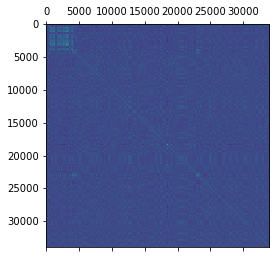

In [25]:
plt.matshow(C1.values @ C1.values.T)

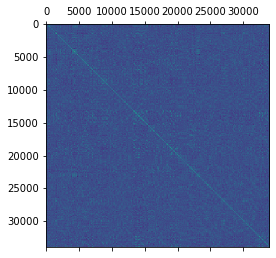

In [26]:
plt.matshow(C2.values @ C2.values.T)

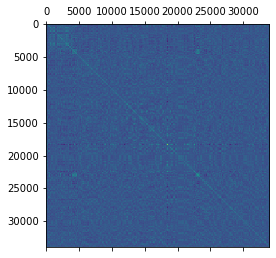

In [26]:
plt.matshow(C1_gauss.values @ C1_gauss.values.T)

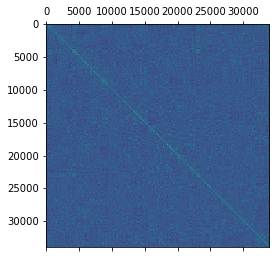

In [28]:
plt.matshow(C2_gauss.values @ C2_gauss.values.T)

In [21]:
#####################################
############ Phenotypes #############
#####################################

In [24]:
# Phenotype (single-cell expression)
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [25]:
#####################################
############ Filter file ############
#####################################

In [26]:
# filter file (columns: snp_id, gene)
endo_eqtl_file = input_files_dir+"endodiff_eqtl_allconditions_FDR10pct.csv"
endo_eqtl = pd.read_csv(endo_eqtl_file, index_col = False)
endo_eqtl["chrom"] = [int(i[:i.find("_")]) for i in endo_eqtl["snp_id"]]
endo_eqtl.head(2)

,snp_id,feature,stage,chrom
0,5_149826526_C_T,ENSG00000164587_RPS14,ips,5
1,11_57283988_C_T,ENSG00000134809_TIMM10,ips,11


In [27]:
chrom = 22
# and consider eGenes on that chromosome
genes = endo_eqtl[endo_eqtl['chrom']==int(chrom)]['feature'].unique()

In [28]:
len(genes)

88

In [29]:
genes

array(['ENSG00000100058_CRYBB2P1', 'ENSG00000184674_GSTT1',
       'ENSG00000196236_XPNPEP3', 'ENSG00000189306_RRP7A',
       'ENSG00000100410_PHF5A', 'ENSG00000093072_CECR1',
       'ENSG00000099974_DDTL', 'ENSG00000100033_PRODH',
       'ENSG00000179750_APOBEC3B', 'ENSG00000099984_GSTT2',
       'ENSG00000100429_HDAC10', 'ENSG00000100122_CRYBB1',
       'ENSG00000133433_GSTT2B', 'ENSG00000128283_CDC42EP1',
       'ENSG00000099942_CRKL', 'ENSG00000215012_C22orf29',
       'ENSG00000100422_CERK', 'ENSG00000100376_FAM118A',
       'ENSG00000099940_SNAP29', 'ENSG00000100417_PMM1',
       'ENSG00000075234_TTC38', 'ENSG00000211643_IGLV5-52',
       'ENSG00000099977_DDT', 'ENSG00000128191_DGCR8',
       'ENSG00000100413_POLR3H', 'ENSG00000185339_TCN2',
       'ENSG00000128294_TPST2', 'ENSG00000185838_GNB1L',
       'ENSG00000184983_NDUFA6', 'ENSG00000185651_UBE2L3',
       'ENSG00000100243_CYB5R3', 'ENSG00000169314_C22orf15',
       'ENSG00000244509_APOBEC3C', 'ENSG00000100347_SAMM50',
    

In [361]:
gene_name = genes[40]
gene_name

'ENSG00000100097_LGALS1'

In [362]:
trait_name = re.sub("_.*","",gene_name)
trait_name

'ENSG00000100097'

In [363]:
leads = endo_eqtl[endo_eqtl['feature']==gene_name]['snp_id'].unique()
G_sel = G[:,G['snp'].isin(leads)]
G_expanded = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == G_expanded.sample.values)
#     trait_name = re.sub("-",".",trait_name)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


In [364]:
y = phenotype.sel(trait=gene_name)
y = quantile_gaussianize(y)
y = y.values.reshape(y.shape[0],1)
n_cells = phenotype.shape[1]
W = ones((n_cells, 1))
GG = G_expanded.values

In [365]:
if (y == 0).astype(int).sum()/len(y)>0.3:
    print("Over 30 percent zeroes, skipping gene")

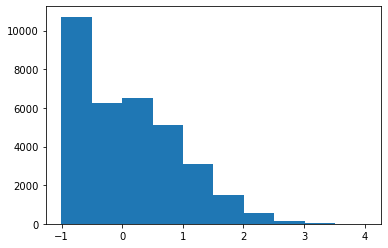

In [366]:
plt.hist(y)
plt.show()

In [ ]:
###

In [367]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:27<00:00, 147.31s/it]


,chrom,pv,variant
0,22,0.496431,22_38059925_A_C


In [368]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:59<00:00, 299.90s/it]


,chrom,pv,variant
0,22,0.43094,22_38059925_A_C


In [369]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:25<00:00, 145.85s/it]


,chrom,pv,variant
0,22,0.628908,22_38059925_A_C


In [ ]:
### ENSG00000133422_MORC2

In [358]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:12<00:00, 156.23s/it]


,chrom,pv,variant
0,22,0.273525,22_31377027_A_G
1,22,0.472266,22_31395825_T_C


In [359]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [09:54<00:00, 297.09s/it]


,chrom,pv,variant
0,22,0.201304,22_31377027_A_G
1,22,0.109643,22_31395825_T_C


In [360]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:14<00:00, 157.22s/it]


,chrom,pv,variant
0,22,0.162442,22_31377027_A_G
1,22,0.349688,22_31395825_T_C


In [ ]:
# to plot in R

## MOFA (pv2)
x = c(8.465845e-10,  2.912894e-02, 3.468064e-10,  0.005462, 0.348159, 0.092094, 0.018068, 0.202231, 0.375638, 
     0.720105, 0.471773, 3.969373e-13, 5.576247e-13, 0.208862, 0.656033, 0.353284, 0.006725, 0.888190, 0.000003, 
     0.011491, 1.328878e-11, 6.727592e-12, 0.436182, 0.686520, 2.398976e-17,  1.300539e-11, 3.080535e-10, 
     3.930914e-09, 0.318595, 0.057419, 0.011458, 0.914385, 0.971026, 0.057087, 0.038254, 0.000005, 0.419376, 
     0.145234, 0.25096, 0.051724, 0.004639, 0.012965, 0.945293, 0.434565, 0.469355, 0.791156, 0.526272, 0.024513,
     0.048411, 0.216436, 0.084545, 0.809697, 0.991218, 0.355933, 0.003093, 0.044061, 0.054433, 0.578994, 0.769611,
     0.17282, 0.000441, 0.586653, 0.237216, 0.115621)

## LDVAE same settings (pv1)
y0 = c(1.103523e-07, 9.014011e-02, 0.000746, 0.000141, 0.316305, 0.015920, 0.004250, 0.113659, 0.258806, 0.342259,
      0.169668, 1.945436e-11, 8.723618e-12, 0.000201, 0.307953, 0.033377, 0.000003, 0.775450, 0.075479, 0.461629,
      0.034528, 0.000027, 0.175667, 0.440837, 2.674606e-07, 0.000772, 0.000173, 0.066520, 0.129119, 0.020621,
      0.003417, 0.647512, 0.454538, 0.137590, 2.631526e-03, 6.865877e-07, 0.047961, 0.147208, 0.036225, 1.186653e-05,
      5.246980e-08, 4.611934e-08, 0.593706, 0.026581, 0.312531, 0.392848, 0.482856, 0.000055, 0.406865, 0.449668,
      0.086945, 0.231502, 0.957537, 0.635569, 0.230927, 0.281954, 0.000331, 0.385409, 0.038905, 0.010509, 0.000105,
      0.530046, 0.074441, 0.297119)

## LDVAE new settings (pv3)
y1 = c(1.913650e-07, 1.247358e-01, 0.000003, 0.000080, 0.266093, 0.063700, 0.010664, 0.105129, 0.452147, 0.622567,
      0.656348, 2.010416e-14, 2.503091e-15, 0.000036, 0.395675, 0.010078, 0.000001, 0.810282,  0.179800, 0.810958,
      0.011071, 0.000676, 0.035383, 0.225566, 4.862919e-08, 0.000266, 0.000696, 0.008577, 0.11841, 0.129038,
      0.00625, 0.510671, 0.407241, 0.032559, 0.005250, 0.000002, 0.230244, 0.22723, 0.031836, 4.559174e-05, 
      2.879162e-07, 1.446790e-07, 0.747629, 0.044543, 0.385746, 0.531140, 0.408399, 0.000131, 0.113757, 0.714947,
      0.061481, 0.704404, 0.898263, 0.638391, 0.078361, 0.108279, 0.000675, 0.817515, 0.048619, 0.008281, 0.000228,
      0.582644, 0.169477, 0.263801)

In [ ]:
### ENSG00000183628_DGCR6

In [349]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:43<00:00, 163.77s/it]


,chrom,pv,variant
0,22,0.297119,22_18888301_G_A


In [350]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [05:01<00:00, 301.50s/it]


,chrom,pv,variant
0,22,0.115621,22_18888301_G_A


In [351]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:53<00:00, 173.66s/it]


,chrom,pv,variant
0,22,0.263801,22_18888301_G_A


In [ ]:
### ENSG00000100083_GGA1

In [340]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:52<00:00, 172.59s/it]


,chrom,pv,variant
0,22,0.074441,22_37905173_A_G


In [341]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [05:13<00:00, 313.01s/it]


,chrom,pv,variant
0,22,0.237216,22_37905173_A_G


In [342]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:51<00:00, 171.08s/it]


,chrom,pv,variant
0,22,0.169477,22_37905173_A_G


In [ ]:
### ENSG00000100196_KDELR3

In [331]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:39<00:00, 159.40s/it]


,chrom,pv,variant
0,22,0.530046,22_38805402_A_T


In [332]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:50<00:00, 290.01s/it]


,chrom,pv,variant
0,22,0.586653,22_38805402_A_T


In [333]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:42<00:00, 162.74s/it]


,chrom,pv,variant
0,22,0.582644,22_38805402_A_T


In [ ]:
### ENSG00000099991_CABIN1

In [322]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:40<00:00, 160.72s/it]


,chrom,pv,variant
0,22,0.000105,22_24335506_C_T


In [323]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [05:32<00:00, 332.19s/it]


,chrom,pv,variant
0,22,0.000441,22_24335506_C_T


In [324]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:30<00:00, 150.85s/it]


,chrom,pv,variant
0,22,0.000228,22_24335506_C_T


In [ ]:
### ENSG00000100292_HMOX1

In [313]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:36<00:00, 156.52s/it]


,chrom,pv,variant
0,22,0.010509,22_35814215_A_G


In [314]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [05:27<00:00, 327.28s/it]


,chrom,pv,variant
0,22,0.17282,22_35814215_A_G


In [315]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:46<00:00, 166.09s/it]


,chrom,pv,variant
0,22,0.008281,22_35814215_A_G


In [ ]:
### ENSG00000100347_SAMM50

In [304]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:39<00:00, 159.51s/it]


,chrom,pv,variant
0,22,0.038905,22_44325748_A_G


In [305]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:55<00:00, 295.89s/it]


,chrom,pv,variant
0,22,0.769611,22_44325748_A_G


In [306]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:33<00:00, 153.53s/it]


,chrom,pv,variant
0,22,0.048619,22_44325748_A_G


In [ ]:
### ENSG00000244509_APOBEC3C

In [295]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:00<00:00, 150.14s/it]


,chrom,pv,variant
0,22,0.000331,22_39376961_C_T
1,22,0.385409,22_39420601_T_C


In [296]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [09:55<00:00, 297.81s/it]


,chrom,pv,variant
0,22,0.054433,22_39376961_C_T
1,22,0.578994,22_39420601_T_C


In [297]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [06:25<00:00, 192.91s/it]


,chrom,pv,variant
0,22,0.000675,22_39376961_C_T
1,22,0.817515,22_39420601_T_C


In [ ]:
### ENSG00000169314_C22orf15

In [286]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:53<00:00, 173.62s/it]


,chrom,pv,variant
0,22,0.281954,22_24105789_G_A


In [287]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [05:22<00:00, 322.93s/it]


,chrom,pv,variant
0,22,0.044061,22_24105789_G_A


In [288]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:39<00:00, 159.28s/it]


,chrom,pv,variant
0,22,0.108279,22_24105789_G_A


In [ ]:
### ENSG00000100243_CYB5R3

In [277]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [04:55<00:00, 147.61s/it]


,chrom,pv,variant
0,22,0.635569,22_42941418_A_G
1,22,0.230927,22_43067139_A_C


In [278]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [09:47<00:00, 293.56s/it]


,chrom,pv,variant
0,22,0.355933,22_42941418_A_G
1,22,0.003093,22_43067139_A_C


In [279]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:12<00:00, 156.20s/it]


,chrom,pv,variant
0,22,0.638391,22_42941418_A_G
1,22,0.078361,22_43067139_A_C


In [ ]:
### ENSG00000185651_UBE2L3

In [268]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:36<00:00, 156.97s/it]


,chrom,pv,variant
0,22,0.957537,22_22077719_C_T


In [269]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:25<00:00, 265.78s/it]


,chrom,pv,variant
0,22,0.991218,22_22077719_C_T


In [270]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:37<00:00, 157.81s/it]


,chrom,pv,variant
0,22,0.898263,22_22077719_C_T


In [ ]:
### ENSG00000184983_NDUFA6

In [259]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:17<00:00, 137.93s/it]


,chrom,pv,variant
0,22,0.231502,22_42453850_T_C


In [260]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [05:14<00:00, 314.14s/it]


,chrom,pv,variant
0,22,0.809697,22_42453850_T_C


In [261]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:47<00:00, 167.39s/it]


,chrom,pv,variant
0,22,0.704404,22_42453850_T_C


In [ ]:
### ENSG00000185838_GNB1L

In [250]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:34<00:00, 154.22s/it]


,chrom,pv,variant
0,22,0.086945,22_19840196_C_G


In [251]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [06:00<00:00, 360.49s/it]


,chrom,pv,variant
0,22,0.084545,22_19840196_C_G


In [252]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:41<00:00, 161.09s/it]


,chrom,pv,variant
0,22,0.061481,22_19840196_C_G


In [ ]:
### ENSG00000128294_TPST2

In [241]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [04:53<00:00, 146.99s/it]


,chrom,pv,variant
0,22,0.406865,22_26980582_T_C
1,22,0.449668,22_27020835_G_A


In [242]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [10:27<00:00, 313.76s/it]


,chrom,pv,variant
0,22,0.048411,22_26980582_T_C
1,22,0.216436,22_27020835_G_A


In [243]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:15<00:00, 157.70s/it]


,chrom,pv,variant
0,22,0.113757,22_26980582_T_C
1,22,0.714947,22_27020835_G_A


In [231]:
### ENSG00000185339_TCN2

In [232]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:39<00:00, 159.33s/it]


,chrom,pv,variant
0,22,0.000055,22_31020400_T_C


In [233]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:49<00:00, 289.30s/it]


,chrom,pv,variant
0,22,0.024513,22_31020400_T_C


In [234]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:36<00:00, 156.23s/it]


,chrom,pv,variant
0,22,0.000131,22_31020400_T_C


In [ ]:
### ENSG00000100413_POLR3H

In [222]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:39<00:00, 159.39s/it]


,chrom,pv,variant
0,22,0.482856,22_41906325_C_T


In [223]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:58<00:00, 298.69s/it]


,chrom,pv,variant
0,22,0.526272,22_41906325_C_T


In [224]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:41<00:00, 161.18s/it]


,chrom,pv,variant
0,22,0.408399,22_41906325_C_T


In [ ]:
### ENSG00000128191_DGCR8

In [214]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:12<00:00, 156.14s/it]


,chrom,pv,variant
0,22,0.312531,22_20062294_C_T
1,22,0.392848,22_20129742_G_C


In [213]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [10:27<00:00, 313.71s/it]


,chrom,pv,variant
0,22,0.469355,22_20062294_C_T
1,22,0.791156,22_20129742_G_C


In [215]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:14<00:00, 157.10s/it]


,chrom,pv,variant
0,22,0.385746,22_20062294_C_T
1,22,0.531140,22_20129742_G_C


In [203]:
### ENSG00000099977_DDT

In [204]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:26<00:00, 163.34s/it]


,chrom,pv,variant
0,22,0.593706,22_24221295_T_G
1,22,0.026581,22_24242973_A_G


In [206]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [10:25<00:00, 312.56s/it]


,chrom,pv,variant
0,22,0.945293,22_24221295_T_G
1,22,0.434565,22_24242973_A_G


In [205]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [04:48<00:00, 144.12s/it]


,chrom,pv,variant
0,22,0.747629,22_24221295_T_G
1,22,0.044543,22_24242973_A_G


In [194]:
### ENSG00000211643_IGLV5-52

In [195]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [09:04<00:00, 181.38s/it]


,chrom,pv,variant
0,22,1.186653e-05,22_22645490_G_A
1,22,5.246980e-08,22_22661150_T_C
2,22,4.611934e-08,22_22663216_A_G


In [196]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [08:49<00:00, 176.48s/it]


,chrom,pv,variant
0,22,4.559174e-05,22_22645490_G_A
1,22,2.879162e-07,22_22661150_T_C
2,22,1.446790e-07,22_22663216_A_G


In [ ]:
### ENSG00000075234_TTC38

In [178]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:25<00:00, 145.24s/it]


,chrom,pv,variant
0,22,0.036225,22_46719054_T_C


In [179]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:25<00:00, 145.14s/it]


,chrom,pv,variant
0,22,0.031836,22_46719054_T_C


In [180]:
C1

<xarray.DataArray (cell: 33964, pc: 10)>
array([[ 0.15835926,  0.5754864 , -1.0920529 , ...,  0.3321673 ,
         0.38922524, -0.34261927],
       [-0.9958191 , -0.03129572,  0.45493168, ...,  0.78643966,
         0.14771053,  0.51670575],
       [ 0.15983821, -0.06117378, -0.2807216 , ...,  0.8091362 ,
        -0.12600906,  0.56088686],
       ...,
       [ 1.2193582 ,  0.28776878, -0.58709943, ...,  0.44366732,
        -0.71827847,  0.14074185],
       [ 0.0851765 ,  0.9583397 , -1.3123212 , ...,  1.3008469 ,
        -0.4053281 ,  0.24936642],
       [ 0.35109466,  0.8765291 , -0.77248335, ...,  1.0291563 ,
        -0.68173134,  0.18897173]])
Coordinates:
  * cell     (cell) object '21843_1#10' '21843_1#100' ... '24539_8#98'
  * pc       (pc) object 'Z_0' 'Z_1' 'Z_2' 'Z_3' ... 'Z_6' 'Z_7' 'Z_8' 'Z_9'

In [186]:
C1_df = pd.DataFrame(data = C1.values, columns = C1.pc.values, index = C1.cell.values)
C1_df.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
21843_1#10,0.158359,0.575486,-1.092053,0.005670,0.892053,-1.105382,0.825755,0.332167,0.389225,-0.342619
21843_1#100,-0.995819,-0.031296,0.454932,0.382779,0.041325,-1.759152,0.771850,0.786440,0.147711,0.516706
21843_1#101,0.159838,-0.061174,-0.280722,0.170650,-0.035520,-1.191214,0.944274,0.809136,-0.126009,0.560887
21843_1#102,0.470313,0.521527,-1.173945,0.033985,0.675836,-0.734045,1.232266,0.388774,0.361199,-0.233932
21843_1#103,0.027621,0.098622,-0.568644,0.061364,0.368514,-0.959623,1.079699,0.547926,-0.010442,0.382205


In [187]:
C1_df.to_csv("/hps/nobackup2/stegle/users/acuomo/CellRegMap_data/ldvae_emb.csv")

In [ ]:
### ENSG00000100417_PMM1

In [165]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:36<00:00, 156.51s/it]


,chrom,pv,variant
0,22,0.147208,22_41877989_A_G


In [166]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:39<00:00, 159.55s/it]


,chrom,pv,variant
0,22,0.22723,22_41877989_A_G


In [ ]:
### ENSG00000099940_SNAP29

In [157]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:48<00:00, 168.55s/it]


,chrom,pv,variant
0,22,0.047961,22_21113793_G_A


In [158]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:45<00:00, 165.37s/it]


,chrom,pv,variant
0,22,0.230244,22_21113793_G_A


In [ ]:
### ENSG00000100376_FAM118A

In [149]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:12<00:00, 156.28s/it]


,chrom,pv,variant
0,22,2.631526e-03,22_45714489_T_C
1,22,6.865877e-07,22_45789743_T_G


In [150]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:12<00:00, 156.38s/it]


,chrom,pv,variant
0,22,0.005250,22_45714489_T_C
1,22,0.000002,22_45789743_T_G


In [ ]:
### ENSG00000100422_CERK

In [141]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [07:37<00:00, 152.44s/it]


,chrom,pv,variant
0,22,0.647512,22_47066294_T_C
1,22,0.454538,22_47076718_T_G
2,22,0.137590,22_47124827_A_C


In [142]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [07:51<00:00, 157.06s/it]


,chrom,pv,variant
0,22,0.510671,22_47066294_T_C
1,22,0.407241,22_47076718_T_G
2,22,0.032559,22_47124827_A_C


In [ ]:
### ENSG00000215012_C22orf29

In [129]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:36<00:00, 156.60s/it]


,chrom,pv,variant
0,22,0.003417,22_19833781_G_A


In [130]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:38<00:00, 158.80s/it]


,chrom,pv,variant
0,22,0.00625,22_19833781_G_A


In [ ]:
### ENSG00000099942_CRKL

In [121]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:39<00:00, 159.49s/it]


,chrom,pv,variant
0,22,0.020621,22_21309934_C_G


In [122]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:39<00:00, 159.39s/it]


,chrom,pv,variant
0,22,0.129038,22_21309934_C_G


In [ ]:
### ENSG00000128283_CDC42EP1

In [113]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:30<00:00, 150.85s/it]


,chrom,pv,variant
0,22,0.129119,22_37949661_A_T


In [114]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:34<00:00, 154.43s/it]


,chrom,pv,variant
0,22,0.11841,22_37949661_A_T


In [ ]:
### ENSG00000133433_GSTT2B

In [105]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [07:34<00:00, 151.52s/it]


,chrom,pv,variant
0,22,0.000772,22_24314006_G_T
1,22,0.000173,22_24323514_C_T
2,22,0.066520,22_24335228_A_C


In [106]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [07:42<00:00, 154.16s/it]


,chrom,pv,variant
0,22,0.000266,22_24314006_G_T
1,22,0.000696,22_24323514_C_T
2,22,0.008577,22_24335228_A_C


In [ ]:
### ENSG00000100122_CRYBB1

In [97]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:34<00:00, 154.90s/it]


,chrom,pv,variant
0,22,2.674606e-07,22_26996946_G_A


In [98]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:42<00:00, 162.95s/it]


,chrom,pv,variant
0,22,4.862919e-08,22_26996946_G_A


In [ ]:
### ENSG00000100429_HDAC10

In [72]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:25<00:00, 162.52s/it]


,chrom,pv,variant
0,22,0.175667,22_50674232_G_A
1,22,0.440837,22_50676459_A_G


In [73]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:35<00:00, 167.51s/it]


,chrom,pv,variant
0,22,0.035383,22_50674232_G_A
1,22,0.225566,22_50676459_A_G


In [ ]:
### ENSG00000099984_GSTT2

In [66]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:00<00:00, 150.28s/it]


,chrom,pv,variant
0,22,0.034528,22_24255296_C_T
1,22,0.000027,22_24323514_C_T


In [67]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [04:54<00:00, 147.10s/it]


,chrom,pv,variant
0,22,0.011071,22_24255296_C_T
1,22,0.000676,22_24323514_C_T


In [ ]:
### ENSG00000179750_APOBEC3B

In [60]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:04<00:00, 152.13s/it]


,chrom,pv,variant
0,22,0.075479,22_39358037_A_C
1,22,0.461629,22_39383918_G_A


In [61]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:08<00:00, 154.32s/it]


,chrom,pv,variant
0,22,0.179800,22_39358037_A_C
1,22,0.810958,22_39383918_G_A


In [ ]:
### ENSG00000100033_PRODH

In [53]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [04:51<00:00, 145.73s/it]


,chrom,pv,variant
0,22,0.000003,22_18909505_T_C
1,22,0.775450,22_18915282_C_T


In [54]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [04:59<00:00, 149.92s/it]


,chrom,pv,variant
0,22,0.000001,22_18909505_T_C
1,22,0.810282,22_18915282_C_T


In [88]:
### ENSG00000099974_DDTL

In [47]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [07:37<00:00, 152.53s/it]


,chrom,pv,variant
0,22,0.000201,22_24302194_G_A
1,22,0.307953,22_24323878_G_A
2,22,0.033377,22_24333977_G_C


In [48]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [07:41<00:00, 153.97s/it]


,chrom,pv,variant
0,22,0.000036,22_24302194_G_A
1,22,0.395675,22_24323878_G_A
2,22,0.010078,22_24333977_G_C


In [ ]:
### ENSG00000093072_CECR1

In [40]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [04:57<00:00, 148.69s/it]


,chrom,pv,variant
0,22,1.945436e-11,22_17680519_A_C
1,22,8.723618e-12,22_17685194_T_A


In [42]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:12<00:00, 156.20s/it]


,chrom,pv,variant
0,22,2.010416e-14,22_17680519_A_C
1,22,2.503091e-15,22_17685194_T_A


In [ ]:
### ENSG00000100410_PHF5A

In [34]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [07:09<00:00, 143.01s/it]


,chrom,pv,variant
0,22,0.258806,22_41806768_C_G
1,22,0.342259,22_41854446_C_T
2,22,0.169668,22_41925535_T_C


In [35]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [07:16<00:00, 145.61s/it]


,chrom,pv,variant
0,22,0.452147,22_41806768_C_G
1,22,0.622567,22_41854446_C_T
2,22,0.656348,22_41925535_T_C


In [ ]:
### ENSG00000189306_RRP7A

In [62]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 3/3 [07:31<00:00, 150.40s/it]


,chrom,pv,variant
0,22,0.015920,22_42896474_T_C
1,22,0.004250,22_42897414_A_C
2,22,0.113659,22_42903671_T_G


In [63]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 3/3 [14:54<00:00, 298.04s/it]


,chrom,pv,variant
0,22,0.092094,22_42896474_T_C
1,22,0.018068,22_42897414_A_C
2,22,0.202231,22_42903671_T_G


In [64]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 3/3 [07:42<00:00, 154.25s/it]


,chrom,pv,variant
0,22,0.063700,22_42896474_T_C
1,22,0.010664,22_42897414_A_C
2,22,0.105129,22_42903671_T_G


In [52]:
### ENSG00000196236_XPNPEP3

In [55]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [05:49<00:00, 174.60s/it]


,chrom,pv,variant
0,22,0.000141,22_41256802_A_G
1,22,0.316305,22_41394128_C_T


In [56]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [11:32<00:00, 346.06s/it]


,chrom,pv,variant
0,22,0.005462,22_41256802_A_G
1,22,0.348159,22_41394128_C_T


In [57]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:45<00:00, 172.74s/it]


,chrom,pv,variant
0,22,0.000080,22_41256802_A_G
1,22,0.266093,22_41394128_C_T


In [45]:
### ENSG00000184674_GSTT1

In [48]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 1/1 [02:32<00:00, 152.35s/it]


,chrom,pv,variant
0,22,0.000746,22_24295427_C_T


In [49]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 1/1 [04:59<00:00, 299.86s/it]


,chrom,pv,variant
0,22,3.468064e-10,22_24295427_C_T


In [50]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 1/1 [02:22<00:00, 142.78s/it]


,chrom,pv,variant
0,22,0.000003,22_24295427_C_T


In [ ]:
### ENSG00000100058_CRYBB2P1

In [40]:
pvals1 = run_interaction(y=y, W=W, E=C1_gauss.values[:,0:10], E1=C1_gauss.values[:,0:10], E2=C1.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv1 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals1,
       "variant":G_expanded.snp.values})
pv1.head()

100%|██████████| 2/2 [04:58<00:00, 149.22s/it]


,chrom,pv,variant
0,22,1.103523e-07,22_25845855_C_G
1,22,9.014011e-02,22_25924999_G_A


In [42]:
pvals2 = run_interaction(y=y, W=W, E=C2_gauss.values[:,0:10], E1=C2_gauss.values[:,0:10], E2=C2.values[:,0:20], G=GG, hK=hK_expanded)[0]
pv2 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals2,
       "variant":G_expanded.snp.values})
pv2.head()

100%|██████████| 2/2 [10:49<00:00, 324.50s/it]


,chrom,pv,variant
0,22,8.465845e-10,22_25845855_C_G
1,22,2.912894e-02,22_25924999_G_A


In [43]:
pvals3 = run_interaction(y=y, W=W, E=C1.values[:,0:10], E1=C1.values[:,0:10], E2=C1.values[:,0:10], G=GG, hK=hK_expanded)[0]
pv3 = pd.DataFrame({"chrom":G_expanded.chrom.values,
       "pv":pvals3,
       "variant":G_expanded.snp.values})
pv3.head()

100%|██████████| 2/2 [05:09<00:00, 154.89s/it]


,chrom,pv,variant
0,22,1.913650e-07,22_25845855_C_G
1,22,1.247358e-01,22_25924999_G_A
